In [1]:
# IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
# HYPERPARAMETERS (Updated)
BATCH_SIZE = 64
EMBEDDING_DIM = 128  # Increased from 50 to 128
UNITS = 128  # Increased from 50 to 128
NUM_EPOCHS = 20  # Increased from 35 to 50

In [3]:
# PREPROCESSING FUNCTION
def preprocess(sent, exclude, sp_tokens=False):
    sent = sent.lower()
    sent = re.sub("'", '', sent)
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.strip()
    sent = re.sub(" +", " ", sent)
    if sp_tokens:
        sent = '<start> ' + sent + ' <end>'
    return sent

class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

def max_length(tensor):
    return max(len(t) for t in tensor)

# DATA LOADING FUNCTION
def data_loader(path, batch_size, samples=None, max_len=None, reverse=False):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    lines = [l.split('\t')[:-1] for l in lines]

    if samples:
        random.shuffle(lines)
        lines = lines[:samples]

    if reverse:
        lines = [l[::-1] for l in lines]

    exclude = set(string.punctuation)

    prep_lines = [
        [preprocess(i, exclude, sp_tokens=False),
         preprocess(j, exclude, sp_tokens=True)]
        for i, j in lines
    ]

    inp_lang = LanguageIndex(en for en, ma in prep_lines)
    tgt_lang = LanguageIndex(ma for en, ma in prep_lines)

    input_tensor = [[inp_lang.word2idx[w] for w in inp.split(' ')]
                    for inp, tgt in prep_lines]

    target_tensor = [[tgt_lang.word2idx[w] for w in tgt.split(' ')]
                     for inp, tgt in prep_lines]

    if max_len:
        new_input_tensor, new_target_tensor = [], []
        for i, j in zip(input_tensor, target_tensor):
            if (len(i) <= max_len) and (len(j) <= max_len):
                new_input_tensor.append(i)
                new_target_tensor.append(j)

        input_tensor, target_tensor = new_input_tensor, new_target_tensor
        max_length_inp = max_length_tgt = max_len
    else:
        max_length_inp, max_length_tgt = max_length(input_tensor), max_length(target_tensor)

    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tgt, padding='post')

    (input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val) = train_test_split(
        input_tensor, target_tensor, test_size=0.1, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train)).batch(batch_size, drop_remainder=True)
    test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(len(input_tensor_val)).batch(batch_size, drop_remainder=True)

    return train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt


In [4]:
# LOAD DATASET
dataset_path = 'urd.txt'
train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader(dataset_path, BATCH_SIZE)

vocab_inp_size = len(inp_lang.word2idx)
vocab_tgt_size = len(tgt_lang.word2idx)

In [5]:
# We have two vocabularies one of english (vocab_inp_size) and the second is what you choose
# which is urdu in my case so it is vocab_tgt_size
print(vocab_inp_size )
print(vocab_tgt_size)

1334
1718


In [6]:
# Detokenize: tokens to string
def detokenize(tokens, idx2word):
    text = ""
    for t in tokens:
        if 'tensorflow' in str(type(tokens)):
            text += idx2word[t.numpy()] + ' '
        else:
            text += idx2word[t] + ' '
    text = text.replace(' <pad>', '')
    text = text.replace('<start>', '')
    text = text.replace('<end>', '')
    return text.strip()

In [7]:
eng, ur_target = next(iter(train_dataset))  # Unpack into two variables
ur_input = ur_target # Since we only have two values, we can assign ur_target to ur_input
print('Shape:', eng.shape, ur_input.shape, ur_target.shape)
print('English Sentence:', detokenize(eng[0], inp_lang.idx2word))
# Choose either ur_input or ur_target for detokenization
print('Urdu Sentence: ', detokenize(ur_input[0], tgt_lang.idx2word))  # Or ur_target[0]

Shape: (64, 18) (64, 23) (64, 23)
English Sentence: i used to love her but not anymore
Urdu Sentence:  میں اس سے پیار کرتا تھا مگر اب نہیں۔


## **Creating Model Architecure**
The encoder encode the English sentence and generates a `context_vector` which is used by decoder to decode the target phrase in urdu!

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embed_dim = embed_dim
        self.units = units
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)

    def call(self, x, mask=None):
        x = self.embedding(x)
        enc_output, state_h, state_c = self.rnn(x, mask=mask)
        return enc_output, state_h, state_c

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "units": self.units,
            "vocab_size": self.vocab_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [9]:
# Testing if Encoder works:
tmp_enc_outputs, tmp_enc_state_h, tmp_enc_state_c = Encoder(
    EMBEDDING_DIM, UNITS, vocab_inp_size
)(eng)

print(tmp_enc_outputs.shape, tmp_enc_state_h.shape, tmp_enc_state_c.shape)

(64, 18, 128) (64, 128) (64, 128)


### **Attention Mechanism**


![image.png](attachment:1b3641d9-f20d-49b7-b640-2d5fdc6f308a.png)

This is a rough sketch of how Attention Mechanism works.

In [10]:
class AdditiveAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)

    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        score = self.W_v(tf.math.tanh(tf.expand_dims(query, 2) + tf.expand_dims(key, 1)))
        score = tf.squeeze(score, -1)

        if mask is not None:
            score = tf.where(mask, score, -1e6)

        attention_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attention_weights, value)
        return context, attention_weights

In [11]:
# DECODER
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embed_dim = embed_dim
        self.units = units
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
        self.attention = AdditiveAttention(units)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        dec_output, state_h, state_c = self.rnn(x, initial_state=state)
        state = (state_h, state_c)

        context_vector, attention_weights = self.attention(dec_output, enc_outputs, enc_outputs, mask)
        context_rnn_output = tf.concat([context_vector, dec_output], axis=-1)
        logits = self.fc(context_rnn_output)
        return logits, state, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "units": self.units,
            "vocab_size": self.vocab_size,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [13]:
# INSTANTIATE AND SAVE MODELS
encoder = Encoder(EMBEDDING_DIM, UNITS, vocab_inp_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, vocab_tgt_size)

In [14]:
# Custom loss function:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)
    return loss

In [15]:
# optimizer:
trainer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [16]:
# This will store loss function value at each epoch
# so we can plot it later
history = {
    'loss': []
}

In [17]:
for epoch in range(NUM_EPOCHS):
    total_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)

            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_state_h, enc_state_c = encoder(x)  # Unpack all three returned values
                dec_states = (enc_state_h, enc_state_c)

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs,
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)

                loss = loss/tf.reduce_sum(tgt_mask)

            variables = (encoder.trainable_variables +
            decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)

    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    print(f'Epoch: {epoch} | Loss: {epoch_loss}')

  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'additive_attention' (of type AdditiveAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch: 0 | Loss: 6.578280597925186


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 | Loss: 5.488347083330154


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 | Loss: 4.947433114051819


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 | Loss: 4.790111184120178


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 | Loss: 4.677517116069794


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 | Loss: 4.578373551368713


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 | Loss: 4.488131910562515


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 | Loss: 4.3875444531440735


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8 | Loss: 4.296041876077652


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9 | Loss: 4.2057293355464935


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Loss: 4.118243724107742


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 | Loss: 4.03567261993885


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 | Loss: 3.9595585614442825


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 | Loss: 3.8829317837953568


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 | Loss: 3.8102257400751114


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 | Loss: 3.7444116920232773


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 | Loss: 3.661326214671135


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 | Loss: 3.5971644669771194


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 | Loss: 3.516099452972412


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 | Loss: 3.4440361708402634


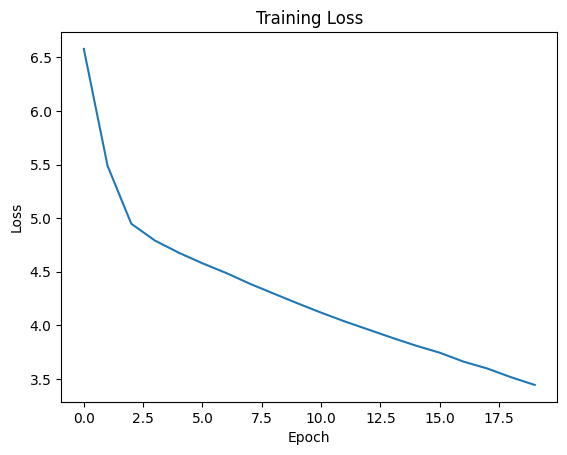

In [18]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
# Predict on new sentences:
def predict_seq2seq(encoder, decoder, src_tokens, tgt_vocab, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    # Modify this line to unpack all three returned values
    enc_outputs, enc_state_h, enc_state_c = encoder(enc_X, training=False)
    # Combine the hidden and cell states into a single state tuple
    dec_state = (enc_state_h, enc_state_c)

    dec_X = tf.expand_dims(tf.constant([tgt_vocab.word2idx['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tgt_vocab.word2idx['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))

    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tgt_vocab.idx2word), attention_weights

In [20]:
eng, ur = next(iter(train_dataset))
idx = -6
actual_seq = detokenize(ur[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'English Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

English Sentence:      please tell everyone im sorry
Predicted Translation: میں نے مجھے کہ میں کہ میں مادری ہے۔
Actual Translation:    برائے مہربانی سب کو بتادو کہ میں شرمندہ ہوں۔


In [21]:
# Save models
encoder.save("encoder_model.h5")
decoder.save("decoder_model.h5")

In [23]:
import gradio as gr
import string
import tensorflow as tf

# Function to preprocess input text
def preprocess(sentence, exclude, sp_tokens=False):
    sentence = ''.join(ch for ch in sentence if ch not in exclude)
    sentence = sentence.lower().strip()
    return sentence

# Function to use the trained model for prediction
def translate_sentence(english_sentence):
    exclude = set(string.punctuation)
    processed_sentence = preprocess(english_sentence, exclude, sp_tokens=False)

    # Convert to tokens
    input_tokens = [inp_lang.word2idx.get(word, 0) for word in processed_sentence.split()]
    input_tokens = tf.keras.preprocessing.sequence.pad_sequences(
        [input_tokens], maxlen=max_length_inp, padding='post'
    )

    # Get prediction
    translated_text, _ = predict_seq2seq(encoder, decoder, input_tokens[0], tgt_lang, max_length_tgt)

    return translated_text

# Define CSS for blue and white theme
custom_css = """
body {
    background-color: #e3f2fd; /* Light Blue */
    font-family: Arial, sans-serif;
}
h1, h2, p {
    color: #1565c0; /* Dark Blue */
    text-align: center;
}
.gradio-container {
    background-color: white;
    padding: 20px;
    border-radius: 10px;
    box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
}
.gr-button {
    background-color: #1976d2 !important;
    color: white !important;
    border-radius: 5px !important;
}
.gr-textbox {
    border: 2px solid #1976d2 !important;
    border-radius: 5px !important;
}
"""

# Create Gradio Interface with blue and white theme
with gr.Blocks(css=custom_css) as iface:
    gr.Markdown("<h1>🌍 English to Urdu Translator</h1>")
    gr.Markdown("<p>Type an English sentence below and get its Urdu translation.</p>")

    with gr.Row():
        lang_choice = gr.Dropdown(["English"], label="Input Language", interactive=False)

    input_text = gr.Textbox(lines=2, placeholder="Enter your English sentence here...", label="Input Sentence")
    output_text = gr.Textbox(label="Translated Sentence", interactive=False)

    translate_btn = gr.Button("Translate")
    translate_btn.click(fn=translate_sentence, inputs=input_text, outputs=output_text)

iface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'additive_attention' (of type AdditiveAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
